In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# udemy_folder = "/content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews"
# !cp {udemy_folder}/udemy_reviews.zip udemy_reviews.zip

#### Load the libraries

In [2]:
!pip install -q -U spacy
!python -m spacy download es_core_news_md

[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.2f}".format

### Connect to drive to get the data

In [4]:
df_udemy = pd.read_csv(f'udemy_reviews.zip', compression='zip', header=0, sep=',', quotechar='"')
df_udemy.head()

,id,course,rating,comment,user
0,73015398,1640654,2.50,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,Jorge Alejandro Castillo
1,50586814,1640654,4.50,Los conocimientos son claros y concisos para lo requerido,Jaime Medina
2,49880684,1640654,5.00,hermoso,Adrián Antonio Herrera Castro
3,47366486,1640654,5.00,Excelente !!!,Márcio Maurício Soares do Nascimento
4,79933910,88380,5.00,Excelente todo!,Emilio Monarrez Hernandez


In [5]:
df_news = df_udemy

In [6]:
# Aplica pos/neg
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
#df_news = df_news[df_news['comment'].str.contains("\s")]
# Filtra los que tienen menos de 5 palabras
df_news = df_news[df_news['comment'].str.split().str.len().gt(4)]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.len() >= 12]
# df_news = df_news[df_news['tag']=='neg']#.sample(2000)

df_news.reset_index(inplace=True)
display(df_news.sample(10))

# Recomendación:
# usar los comentarios con >=5 palabras


,index,id,course,rating,comment,user,tag
73885,96321,35344442,2353450,3.00,Me ha parecido demasiado básico para ser de pago :C,Jonathan Contreras Vargas,neg
22310,28937,9664048,201562,2.50,El temario es bueno pero le falta mayor explicacion,Andrés Fernando Valenzuela Saavedra,neg
86786,114903,23082690,405252,5.00,"Me han gustado las sesiones, ahora solo me falta practicar lo aprendido, gracias",Rosaura Lee Fonseca,pos
72921,95092,75143902,571730,5.00,"bastante bien, eso no lo enseñan en la escuela",Leonel Lopez,pos
107331,144190,69245710,1576314,4.00,"Pues está bien, te va mostrando desde lo más básico.",Jose Corona,pos
35071,45464,31599372,2228648,5.00,"si, muy buena. Algunos problemas técnicos con el adobe que impedían en algunas ocasiones la reproducción, pero saliendo de la plataforma y volviendo a entrar y se subsanaban.",Victor Valencia Torres,pos
126160,170926,54023274,2962192,5.00,"Excelente!!! El instructor es muy claro y didáctico, muchas gracias, me ha servido mucho para el desarrollo de mis habilidades",Carmen Elena Guerrero DelgadoD,pos
62888,81838,78080104,3069956,5.00,Este curso está súper entendible,Liliana Maldonado,pos
125291,169664,57724807,1875536,5.00,que asombrado de cuan uno olvida los conceptos basicos y lo importante es saber esta materia.,Marco Arancibia Ramirez,pos
103755,139204,61149798,174302,4.00,"Es un inicio bueno aunque algo tibio, te muestra un panorama muy amplio sin profundidad, aunque esperaría encontrar esa profundidad en curso que promociona este instructor",Javier Tellez,pos


In [7]:
sum(df_news.tag == 'pos')

109577

In [8]:
sum(df_news.tag == 'neg')

18883

In [9]:
df_news[df_news['id'].isin([76629358,52215828])]

,index,id,course,rating,comment,user,tag
6962,9035,52215828,1922200,3.00,"El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han sido de mucha utilidad. Encontré deficiencias en el material de apoyo y la sección 22. El lanzamiento no fue muy clara, pero en general se adquiere un gran conocimiento de scrum scale",Diana Forero,neg
42344,54928,76629358,3446356,3.50,"Buenos días, si estás leyendo este comentario, te recomiendo leerlo entero para tener un contexto global del por que dejo solo 3 estrellas. Primero dejaré unos puntos clave y luego la explicación.\n\nPrólogo: Enhorabuena a Nicolas Schurmann por su trabajo y acercar a más gente al mundo del desarrollo, y enhorabuena por el curso que pese a no cuadrar conmigo está muy bien.\n\nPrimero: El curso lo recibí de forma gratuita por una promoción.\nSegundo: Lo explicado en el curso, está bien explicado.\nTercero: Recomiendo el curso a cualquier persona que no tenga ningún conocimiento del mundo de desarrollo.\nCuarto: No recomiendo el curso a las personas que ya tengan contacto con el mundo del desarrollo. \nQuinto: Soy desarrollador Junior trabajando con lenguajes POO como Java y C# en mi día a día. \nSexto: A la hora de escribir este comentario miré y practiqué hasta la sección 12 (inclusive).\n\nExposición: \nEl título expone muchas tecnologías, cosa que ya me decía que faltarían aspectos interesantes por tocar, yo ya se lo básico de HTML, CSS y algo más avanzado en MySQL, no se que es Flask y no conocía la sintaxis de Python. Mi interés en este curso es principalmente Python, nada más, aún que veré el resto de secciones por si acaso. \n\nDicho esto la sección de Python me parece demasiado básica, echando en falta explicación de conceptos como; ámbito de vida de las variables, uso de variables de forma global, funcionamiento extendido a la hora de iterar diccionarios y otro tipo de colecciones, propagación de excepciones y algunos temas más avanzados. \n\nPilares de la OO, se explica la creación de clases y su herencia, pero no se explican conceptos como el polimorfismo que me parece de vital importancia en la POO, tampoco se hace mención a la abstracción y el encapsulamiento, pese a explicar la creación de funciones en clases al ser python un lenguaje no tipado (o poco tipado) no queda claro el tema del encapsulamiento, no se explica en el curso, en las clases creadas siempre se tiene acceso a las propiedades y eso va en contra de este principio.\n\nEn un capítulo se explica la recursividad, es algo muy potente pero que si no se tienen conocimientos puede dar pie a confusión y errores, desearía algún ejemplo más de recursividad para los más inexpertos. \n\nEn resumen, falta un poco de explicación teórica sobre los principios de la POO y falta algo más de contenido sobre Python, lo explicado está perfectamente explicado (menos la recursividad en mi opinión). \n\nCon el título ""python sin fronteras"" esperaba mucho más contenido sobre python, como dije el curso lo recomiendo a cualquier persona que quiera iniciarse, pero si ya controlas aún que sea como junior algún lenguaje de programación, no creo que este curso sea para ti. \n\nMe sabe mal dejar tan baja puntuación a Nicolas Schurmann por que su contenido es muy bueno, tanto en esta plataforma como en otras, pero no me queda más remedio que ser objetivo, quizás si el título fuera algo así como ""Iniciación en Python"" o algo similar no hubiera escrito este comentario y le hubiera dado 4.5 estrellas o 5, ya que es 100% apto para los no iniciados. \n\nSin más me despido, un saludo y espero os toméis este comentario como lo que es, un comentario que intenta dar un punto de vista como un junior que quiere aprender.",Ramón Martínez Nieto,neg


In [10]:
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


In [11]:
df_news['tag'].value_counts()

pos    109577
neg     18883
Name: tag, dtype: int64

In [12]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128460 entries, 0 to 128459
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   index    128460 non-null  int64  
 1   id       128460 non-null  int64  
 2   course   128460 non-null  int64  
 3   rating   128460 non-null  float64
 4   comment  128460 non-null  object 
 5   user     128459 non-null  object 
 6   tag      128460 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 6.9+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

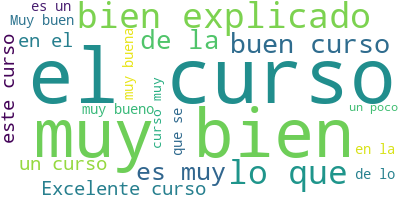

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_news['comment'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=20, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [15]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = ['excelente', 'buen','bien',
              'muchas', 'gracias', 'curso','course','good'
              ]

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

In [16]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

Wall time: 46.4 s


In [17]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in stopwords_sp:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [18]:
cleaner('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo',
 'adentraste',
 'informaste',
 'publicar',
 'mejor',
 'facebook',
 'recomendacion',
 'mejora',
 'diccion']

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

For gensim we need a list of text, so we need do convert the dataframe to list

In [19]:
stemmization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción')

['curso',
 'gracias',
 'amigo',
 'me',
 'adentraste',
 'e',
 'informaste',
 'como',
 'publicar',
 'mejor',
 'en',
 'facebook',
 'ads',
 'recomendacion',
 'mejora',
 'tu',
 'diccion']

In [20]:
lemmatization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo', 'recomendación', 'dicción']

In [21]:
len(df_news)

128460

In [22]:
# !python -m spacy download es_core_news_md

In [23]:
df_news['comment'].sample(3)

77772                                                                                  Uno de los cursos más completos que vi de Wordpress, con lo mucho que me cuesta php, logré terminar el sitio de wordpress básico en un día. Muy genial!
48064    A mi gusto el curso, muy bien explicado. Es ideal para aprender desde 0. Lo único que le faltaría para mi gusto es algún proyecto con display o motor paso a paso. Lo recomiendo para empezar a utilizar arduino en nuevos proyectos.
82826                                                                                                                                                                          buenisima, para complementar conocimiento, recomendare if o if.
Name: comment, dtype: object

In [24]:
cleaner(df_news['comment'].iloc[3])

['interesante',
 'tematica',
 'guia',
 'unico',
 'desmotiva',
 'musica',
 'fondo',
 'habla',
 'parece',
 'circo',
 'desafin']

The Cleaner function work properly

##### Let's clean all the text

In [25]:
from tqdm import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].progress_apply(cleaner)

100%|██████████| 128460/128460 [01:41<00:00, 1261.75it/s]


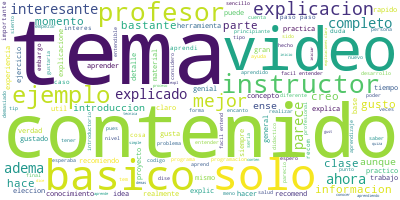

In [26]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list([' '.join(map(str, l)) for l in df_news['comment_cleaned']]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [27]:
# las palabras "curso,clase" son stopwords

In [195]:
df_news['comment_cleaned'].iloc[200:210]

200                                                                                                                                                                                                                                                                                                                                                                                       [dicho, leyendo, pueda, saber, facil]
201                                                                                                                                                                                                                                                                                                                                                                                                        [explicado, complet]
202                                                                                                                                                                     

In [196]:
dictionary = Dictionary(df_news['comment_cleaned'].to_list())
dictionary.compactify()
# Filter extremes
#dictionary.filter_extremes(no_below=5, no_above=0.3)#, keep_n=10000)
#dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]

In [197]:
# Aplano la lista
def flatten(t):
    return [item for sublist in t for item in sublist]

In [198]:
# Creo lista de positivos y negativos
muestra = 10000
lista_negativos = flatten(df_news[df_news['tag']=='neg'].sample(muestra)['comment_cleaned'].to_list())
print(lista_negativos[:10])
lista_positivos = flatten(df_news[df_news['tag']=='pos'].sample(muestra)['comment_cleaned'].to_list())
print(lista_positivos[:10])

['basico', 'ganas', 'compr', 'tutorial', 'metodologia', 'aplicada', 'proceso', 'felicit', 'complicado', 'adaptarme']
['experiencia', 'aprendiendo', 'usar', 'maxent', 'conociendo', 'fuentes', 'informacion', 'definitivamente', 'instruyendome', 'estudios']


In [199]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''  
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df = 10, max_df = .5, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))
    return return_list

In [200]:
a = bayes_compare_language(lista_positivos,lista_negativos, prior=0.01)

Vocab size is 2516
Comparing language...


In [201]:
# Palabras más negativas
a[:10]

[('falta', -13.77984802252577),
 ('podria', -11.29253254389741),
 ('demasiado', -11.120040472226602),
 ('video', -11.029152844322793),
 ('deberia', -10.922476804575838),
 ('solo', -10.510840820588434),
 ('videos', -10.479379096340692),
 ('esperaba', -10.466770756889856),
 ('audio', -9.444754826152977),
 ('creo', -9.196482424675278)]

In [202]:
# Palabras más positivas
a[-10:]

[('super', 10.794375070464929),
 ('clara', 11.557824872977728),
 ('completo', 11.716901279420437),
 ('gran', 12.063101332867522),
 ('recomend', 12.552838503396382),
 ('explic', 13.49531160348064),
 ('eleccion', 14.423112573546248),
 ('facil', 14.708605261845422),
 ('claro', 15.274533071803525),
 ('explicado', 19.380796870170368)]

In [203]:
# Creo lista de positivos y negativos
muestra = 2000
lista_negativos = flatten(df_news[df_news['tag']=='neg'].sample(muestra)['comment_cleaned'].to_list())
print(lista_negativos[:10])
lista_positivos = flatten(df_news[df_news['tag']=='pos'].sample(muestra)['comment_cleaned'].to_list())
print(lista_positivos[:10])

['desactualizado', 'existen', 'gratuitos', 'mejores', 'aprender', 'ense', 'justifica', 'preci', 'entretenido', 'instructor']
['aprendiendo', 'nuevas', 'cosas', 'ademas', 'refrescar', 'conocimientos', 'adquiri', 'hace', 'varios', 'razones']


In [204]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''  
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language_deltas(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df = 10, max_df = .5, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    deltas = np.empty(priors.shape[0]) #agregado
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
        deltas[i] = delta # Agregado
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
#     sorted_indices = np.argsort(z_scores) #Agregado
    sorted_indices = np.argsort(deltas) #Agregado
    return_list = []
    for i in sorted_indices:
#         return_list.append((index_to_term[i], z_scores[i])) #Agregado
        return_list.append((index_to_term[i], z_scores[i], deltas[i])) # Agregado
    return return_list

In [205]:
a = bayes_compare_language_deltas(lista_positivos,lista_negativos,prior=0.01)

Vocab size is 708
Comparing language...


In [206]:
# Palabras más negativas
a[:10]

[('escucha', -0.7179872191861927, -7.181982367423098),
 ('pesimo', -0.7179872191861927, -7.181982367423098),
 ('tedioso', -0.6910943633091414, -6.913599135065722),
 ('superficial', -0.6910943633091414, -6.913599135065722),
 ('leyendo', -0.6830702298634818, -6.8335454630861925),
 ('cort', -0.6743473031881739, -6.746534767808791),
 ('comentarios', -0.6647920595365868, -6.651240406107301),
 ('lamentablemente', -0.6647920595365868, -6.651240406107301),
 ('supone', -0.6647920595365868, -6.651240406107301),
 ('descargar', -0.6647920595365868, -6.651240406107301)]

In [207]:
b = pd.DataFrame(a)
b.columns = ['palabra','zscore','delta']
b

,palabra,zscore,delta
0,escucha,-0.72,-7.18
1,pesimo,-0.72,-7.18
2,tedioso,-0.69,-6.91
3,superficial,-0.69,-6.91
4,leyendo,-0.68,-6.83
...,...,...,...
703,sigo,2.33,2.45
704,recomend,5.27,2.48
705,trabaj,2.55,2.65
706,angular,0.73,7.35


In [208]:
# Palabras más positivas
a[-10:]

[('perfectamente', 2.8064740180612833, 2.1269599643596546),
 ('detallado', 3.6608387248015615, 2.2497330085571274),
 ('super', 5.353937770658582, 2.3193207803126343),
 ('encanto', 3.1200106143167923, 2.334746699559619),
 ('encant', 2.3323977594566427, 2.4474475528823145),
 ('sigo', 2.3323977594566427, 2.4474475528823145),
 ('recomend', 5.270949744785548, 2.4797855390986543),
 ('trabaj', 2.5470545454963966, 2.648110680870867),
 ('angular', 0.734728078821595, 7.350338969737856),
 ('fernando', 0.7635817179227117, 7.638201509395837)]

In [210]:
# Ngrams (se podría armar con N-grams no le encontré la vuelta)

In [211]:
lista = []
for i in range(df_news.shape[0]):
    lista.append(" ".join(df_news.comment_cleaned[i]))

In [212]:
df_news['comment_cleaned_concat'] = lista
df_news.head()

,index,id,course,rating,comment,user,tag,comment_cleaned,comment_cleaned_concat
0,0,73015398,1640654,2.50,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,Jorge Alejandro Castillo,neg,"[introduccion, deberian, hacerlo, dirigido, fotos, rp]",introduccion deberian hacerlo dirigido fotos rp
1,1,50586814,1640654,4.50,Los conocimientos son claros y concisos para lo requerido,Jaime Medina,pos,"[conocimientos, claros, concisos, requer]",conocimientos claros concisos requer
2,5,77234376,88380,3.00,Explican poco... se lee la mayoría,Tristán,neg,"[explican, mayori]",explican mayori
3,6,68942466,88380,4.00,"Muy interesante la temática y la guía, lo único que desmotiva, es la música de fondo cuando habla Noe, parece de circo desafinado",José Jaime Olavarrieta Bayrer,pos,"[interesante, tematica, guia, unico, desmotiva, musica, fondo, habla, parece, circo, desafin]",interesante tematica guia unico desmotiva musica fondo habla parece circo desafin
4,7,65065272,88380,5.00,hasta ahora me ha gustado el contenido del curso,Lorena Quintana Romero,pos,"[ahora, gustado, conten]",ahora gustado conten


In [213]:
# Creo lista de positivos y negativos
muestra = 10
lista_negativos = " ".join(df_news[df_news['tag']=='neg'].sample(muestra)['comment_cleaned_concat'])
print(lista_negativos)
lista_positivos = " ".join(df_news[df_news['tag']=='pos'].sample(muestra)['comment_cleaned_concat'])
print(lista_positivos)

claro orientativo encuentra nivel inicial sabe arrancar agradece esfuerzo tutorial pueda encontrar internet pesar recomiendan tener control velocidad habla expositor habla demasiado lento videos doble veloc basic moemt eleccion agradece contenido explicado salud falt improvisa profesor equivoca veces explicaciones entendible verlo varias veces buscar fuentes complemento tema mysql procedimientos almacen demasiado interactivo menos udemy gustaria enfocado demore comentarios usuarios temas live streaming rapido explica detenidamente cosas salta pasos distrae v seguimiento proyecto explica repente explicado avanza cuenta propia luego capitulos despues retoma leccion archivo avanzado quieres aprender teoria forma separada practica confusa aburrida decepcionado youtube seguir aprendiendo ingles videos gratis ense mejor
abarca detalles explic genial julio explica perfeccion buscando hora comenzar programar verdad quedado claro agradezco realiz guia rapida transparente entender bases metodolo